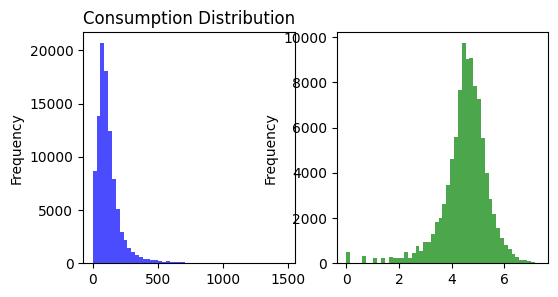

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from functions import calculate_price, calculate_appliance_score
from datetime import datetime
from scipy.stats import pearsonr, spearmanr
pd.set_option('display.max_columns', None)
import statsmodels.api as sm

#data
nsm = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/non_smart_meter/monthly_consumption.csv')
wave_1_houseinfo = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')
appliance = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_appliances.csv')
nsm['consumption'] = pd.to_numeric(nsm['consumption'], errors='coerce')


# Filtering smart meter data from anomolous very low and very high values
nsm = nsm[(nsm['consumption'] > 0) & (nsm['consumption'] < 1500)]
# reindex nsm by consumption
#nsm = nsm.sort_values(by='consumption').reset_index(drop=True)
#log transform consumption
nsm['log_consumption'] = nsm['consumption'].apply(lambda x: 0 if x <= 0 else np.log(x))



#plot consumption, log consumption side by side
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
nsm['consumption'].plot(kind='hist', ax=ax[0], bins=50, color='blue', alpha=0.7)
nsm['log_consumption'].plot(kind='hist', ax=ax[1], bins=50, color='green', alpha=0.7)
ax[0].set_title('Consumption Distribution')

grouped = nsm.groupby('household_ID')['consumption'].mean()
avg = pd.DataFrame(grouped)
avg = calculate_price(avg)

merged = avg.merge(wave_1_houseinfo[['household_ID', 'total_monthly_expenditure_of_last_month', 'no_of_household_members', 'socio_economic_class']], on='household_ID', how='left')
merged['expense_per_member'] = merged['total_monthly_expenditure_of_last_month'] / merged['no_of_household_members']
merged['electricity_per_member'] = merged['price'] / merged['no_of_household_members']
    
merged['expenditure_category'] = pd.qcut(
    merged['total_monthly_expenditure_of_last_month'],
    q=5,
    labels=['Very low', 'Low', 'Medium', 'High', 'Very high']
)

merged['per_member_expenditure_category'] = pd.qcut(
    merged['expense_per_member'],
    q=5,
    labels=['Very low', 'Low', 'Medium', 'High', 'Very high']
)

merged['per_member_electricity_category'] = pd.qcut(
    merged['electricity_per_member'],
    q=5,
    labels=['Very low', 'Low', 'Medium', 'High', 'Very high']
)

merged['percentage_expenditure'] = (merged['price'] / merged['total_monthly_expenditure_of_last_month']) * 100

merged = merged[merged['percentage_expenditure'] <= 40]

# Socio-demographic factors

1. x% of the variation in electricity is explained by the variation in socio-demographic factors.
2. Significantly inverse relationship between household size and per-capita household electricity consumption
3.
4. No of children positively associate with electricity consumption
5. An additional child in the family increases the electrctricity expenditure by X.XX% on average
6. Significant negative relationship between no of employed members and household electricity demand
7. On average household with many retired-people consume x% more electriciy then households without retirees.
8. Significant positive relationship between energy demand and the number of elderly people
9. U-shaped relationship between expenditure and electricity consumption
10. level of education of household members is negatively associated with household electricity expenditure
11. Household head's age and electricity expenditure and household head over xy have lower electricity consumption
12. Female or male headed households consume less than ..., male headed efficient usage of appliances

## 1.1 Significantly inverse relationship between household size and per-capita household electricity consumption

Text(0.5, 1.0, 'Household Size vs Total Electricity Consumption')

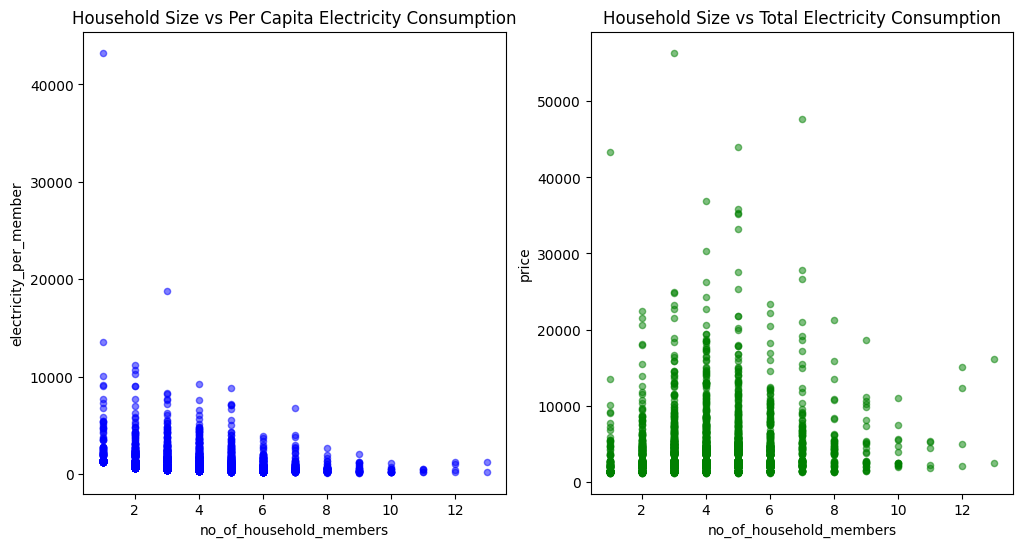

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
merged.plot.scatter(x='no_of_household_members', y='electricity_per_member', ax=ax[0], color='blue', alpha=0.5)
merged.plot.scatter(x='no_of_household_members', y='price', ax=ax[1], color='green', alpha=0.5)
ax[0].set_title('Household Size vs Per Capita Electricity Consumption')
ax[1].set_title('Household Size vs Total Electricity Consumption')

In [7]:
x = merged['no_of_household_members']
y = merged['electricity_per_member']

# Pearson correlation test (linear relationship)
pearson_corr, pearson_p = pearsonr(x, y)
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_p:.5f}")

# Spearman correlation test (monotonic relationship)
spearman_corr, spearman_p = spearmanr(x, y)
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p:.5f}")

Pearson correlation: -0.245, p-value: 0.00000
Spearman correlation: -0.443, p-value: 0.00000


## 1.2. No of children positively associate with electricity consumption

In [8]:
children = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_demographics.csv')

# groupby household_ID and count number of age less than 18
children['children'] = children.groupby('household_ID')['age'].transform(lambda x: (x < 18).sum())
children = children[['household_ID', 'children']].drop_duplicates()
children['has_children'] = (children['children'] > 0).astype(int)
merged = merged.merge(children, on='household_ID', how='left')
# merged = merged[merged['socio_economic_class'] == 'SEC D']

In [9]:
X = sm.add_constant(merged['children'])
y = merged['price']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.144
Date:                Fri, 06 Jun 2025   Prob (F-statistic):            0.00434
Time:                        15:46:38   Log-Likelihood:                -37206.
No. Observations:                3858   AIC:                         7.442e+04
Df Residuals:                    3856   BIC:                         7.443e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3559.0220     79.128     44.978      0.0

## 1.3 Significant negative relationship between no of employed members and household electricity demand

In [10]:
emplyed = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_demographics.csv')

# to a new column add zero if 'employment_status_of_the_main_occupation' empty, or 'Contributing family worker' else 1
emplyed['employment_status_of_the_main_occupation'] = emplyed['employment_status_of_the_main_occupation'].fillna('Contributing family worker')
emplyed['is_employed'] = emplyed['employment_status_of_the_main_occupation'].apply(lambda x: 0 if x == 'Contributing family worker' else 1)

emplyed['no_of_employees'] = emplyed.groupby('household_ID')['is_employed'].transform(lambda x: (x == 1).sum())
emplyed['no_of_unemployees'] = emplyed.groupby('household_ID')['is_employed'].transform(lambda x: (x ==0).sum())
emplyed = emplyed[['household_ID', 'no_of_employees', 'no_of_unemployees']].drop_duplicates()

In [11]:
merged = merged.merge(emplyed, on='household_ID', how='left')
x = merged['no_of_employees']
y = merged['electricity_per_member']

# Pearson correlation test (linear relationship)
pearson_corr, pearson_p = pearsonr(x, y)
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_p:.5f}")

# Spearman correlation test (monotonic relationship)
spearman_corr, spearman_p = spearmanr(x, y)
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p:.5f}")

Pearson correlation: -0.095, p-value: 0.00000
Spearman correlation: -0.166, p-value: 0.00000


Text(0.5, 1.0, 'Household Size vs Total Electricity Consumption')

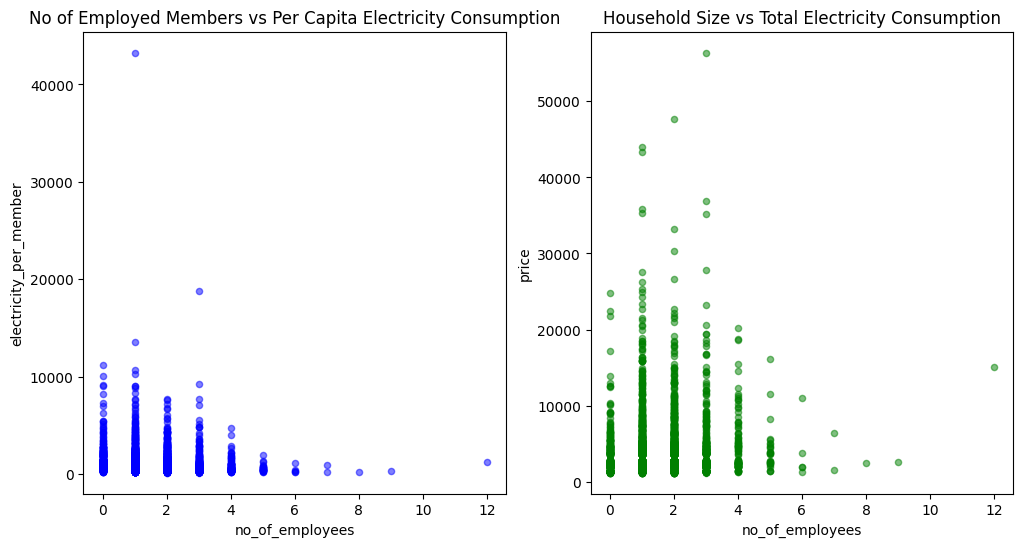

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
merged.plot.scatter(x='no_of_employees', y='electricity_per_member', ax=ax[0], color='blue', alpha=0.5)
merged.plot.scatter(x='no_of_employees', y='price', ax=ax[1], color='green', alpha=0.5)
ax[0].set_title('No of Employed Members vs Per Capita Electricity Consumption')
ax[1].set_title('Household Size vs Total Electricity Consumption')

## 1.4 On average household with many retired-people consume 20% more electriciy then households without retirees.

In [13]:
merged['has_retiree'] = merged['no_of_unemployees'] > 0
X = sm.add_constant(merged['has_retiree'].astype(int))
model = sm.OLS(merged['consumption'], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            consumption   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     14.27
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           0.000160
Time:                        15:46:38   Log-Likelihood:                -22723.
No. Observations:                3858   AIC:                         4.545e+04
Df Residuals:                    3856   BIC:                         4.546e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          98.2134      5.127     19.157      

Text(0.5, 0, 'Has Retiree (0 = No, 1 = Yes)')

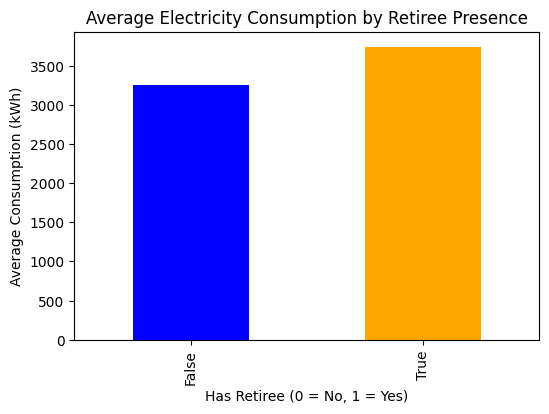

In [14]:
# plotmerged.has_retiree vs price
fig, ax = plt.subplots(figsize=(6, 4))
merged.groupby('has_retiree')['price'].mean().plot(kind='bar', ax=ax, color=['blue', 'orange'])
ax.set_title('Average Electricity Consumption by Retiree Presence')
ax.set_ylabel('Average Consumption (kWh)')
ax.set_xlabel('Has Retiree (0 = No, 1 = Yes)')

## 1.5 level of education of household members is negatively associated with household electricity expenditure

In [15]:
emplyed = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_demographics.csv')

education_encoding = {
    'No Schooling': 0,
    'Special Education learning / learnt': 0.5,
    'Passed Grade 1': 1,
    'Passed Grade 2': 2,
    'Passed Grade 3': 3,
    'Passed Grade 4': 4,
    'Passed Grade 5': 5,
    'Passed Grade 6': 6,
    'Passed Grade 7': 7,
    'Passed Grade 8': 8,
    'Passed Grade 9': 9,
    'Passed Grade 10': 10,
    'Passed Grade 12': 11,  # Assuming Grade 12 means A/L prep year
    'Passed G.C.E.(O/L)': 11,
    'Passed G.C.E.(A/L) or equivalent': 12,
    'Passed GAQ (General Arts Qualifying (External) Examination)/GSQ (General Science Qualifying examination)': 13,
    'Passed Degree / Diploma': 14,
    'Passed post Graduate Degree / Diploma': 15,
    'PhD': 16,
    'Studying/Studied Grade 1': 1,  # Treated same as Passed Grade 1
    np.nan: np.nan  # leave as NaN or impute later
}

emplyed['education_encoded'] = emplyed['highest_level_of_education'].map(education_encoding)

emplyed['education_level'] = emplyed.groupby('household_ID')['education_encoded'].transform('sum')
emplyed = emplyed[['household_ID', 'education_level']].drop_duplicates()
merged = merged.merge(emplyed, on='household_ID', how='left')

In [16]:
x = merged['education_level']
y = merged['electricity_per_member']

# Pearson correlation test (linear relationship)
pearson_corr, pearson_p = pearsonr(x, y)
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_p:.5f}")

# Spearman correlation test (monotonic relationship)
spearman_corr, spearman_p = spearmanr(x, y)
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p:.5f}")

Pearson correlation: -0.127, p-value: 0.00000
Spearman correlation: -0.231, p-value: 0.00000


Text(0.5, 1.0, 'Household Size vs Total Electricity Consumption')

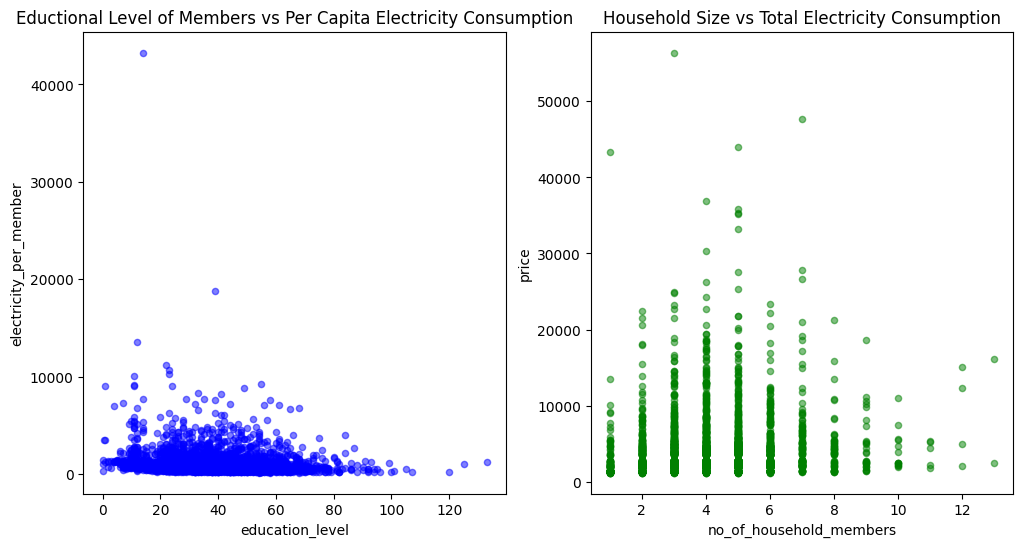

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
merged.plot.scatter(x='education_level', y='electricity_per_member', ax=ax[0], color='blue', alpha=0.5)
merged.plot.scatter(x='no_of_household_members', y='price', ax=ax[1], color='green', alpha=0.5)
ax[0].set_title('Eductional Level of Members vs Per Capita Electricity Consumption')
ax[1].set_title('Household Size vs Total Electricity Consumption')

# Building factors

1. Positive relationship between no of rooms and electricity expenditure
2. household with one or two rooms consume significantly less than 5 or more (3 times or whatever), each additional room causes x% to increase
3. We found house-ownership and household electricity expenditure are also associated with each other
homeowners saving on electricity x% of the total electiricy expenditure of renters
4. floor area vs coonsumption

## 2.1 household with one or two rooms consume significantly less than 5 or more (3 times or whatever), each additional room causes x% to increase

In [33]:
rooms = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_room_roster.csv', low_memory=False)

#count the no of rows for a household id
rooms['no_of_rooms'] = rooms.groupby('household_ID')['room_ID'].transform('count')
rooms = rooms[['household_ID', 'no_of_rooms']].drop_duplicates()
merged = merged.merge(rooms, on='household_ID', how='left')

X = sm.add_constant(merged['no_of_rooms'])
y = merged['price']

model = sm.OLS(y, X).fit()
print(model.summary())

KeyError: 'no_of_rooms'

In [32]:
(440 / 2000 ) * 100

22.0

## 2.2 We found house-ownership and household electricity expenditure are also associated with each other homeowners saving on electricity x% of the total electiricy expenditure of renters

In [19]:
# if wave_1_houseinfo.own_the_house_or_living_on_rent == 'Yes, I or a household member owns it.' assign 1 otherwise 0
merged['owns_house'] = (wave_1_houseinfo['own_the_house_or_living_on_rent'] == 'Yes, I or a household member owns it.').astype(int)
merged['floor_area'] = wave_1_houseinfo['floor_area'].fillna(0)

In [20]:
X = sm.add_constant(merged['owns_house'])
y = merged['price']

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6695
Date:                Fri, 06 Jun 2025   Prob (F-statistic):              0.413
Time:                        15:46:39   Log-Likelihood:                -37210.
No. Observations:                3858   AIC:                         7.442e+04
Df Residuals:                    3856   BIC:                         7.444e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3831.4383    164.852     23.242      0.0

In [30]:
144 / 2000 * 100

7.199999999999999

# Appliance related factors

1. largest share of household expenditure x% is explained by appliance-related factors
2. significant positive relationship between stock of electrical appliances and electricity expenditure
3. cooling vs expenditure is significant
4. having a refrigerator increases significantly

## 3.1 significant positive relationship between stock of electrical appliances and electricity expenditure

Text(0.5, 1.0, 'Household Size vs Total Electricity Consumption')

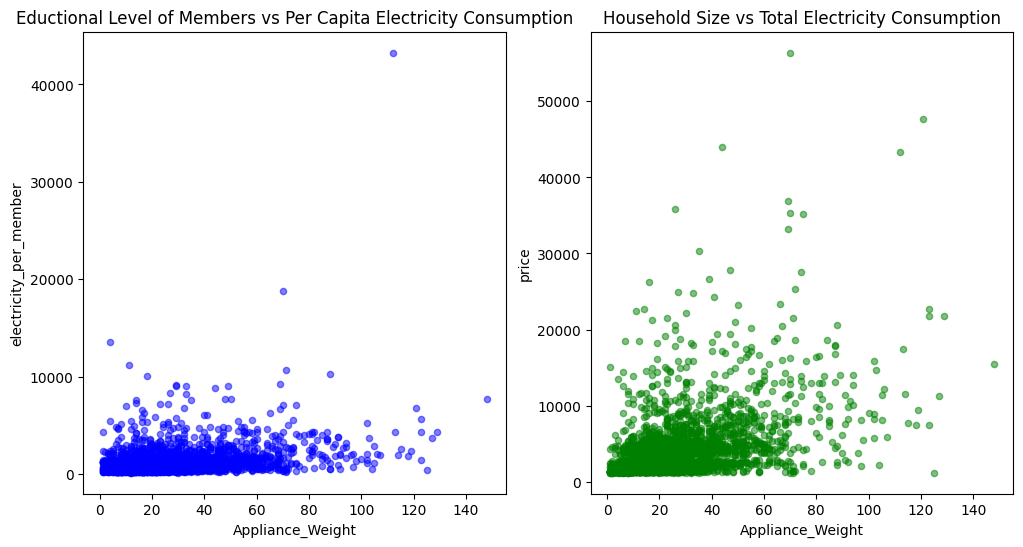

In [21]:
app = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_appliances.csv')
app = calculate_appliance_score(app)
merged = merged.merge(app, on='household_ID', how='left')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
merged.plot.scatter(x='Appliance_Weight', y='electricity_per_member', ax=ax[0], color='blue', alpha=0.5)
merged.plot.scatter(x='Appliance_Weight', y='price', ax=ax[1], color='green', alpha=0.5)
ax[0].set_title('Eductional Level of Members vs Per Capita Electricity Consumption')
ax[1].set_title('Household Size vs Total Electricity Consumption')

We model how households' absolute and relative burden of monthly electricity expenditures are determined using the same vector of covariates.
Vector of covariates = 

When modeling absolute burden we use log transformed data of households monthly electricity expenditure and estimate a semi-log model where regression coefficients can be interpreted as percentage change in monthly electricity expenditure when changing an independant variable by one unit. 

log(Electricity Expenditure 
i
​
 )=β 
0
​
 +β 
1
​
 X 
1i
​
 +β 
2
​
 X 
2i
​
 +…+ϵ 
i

We’re using a semi-log model, which means the dependent variable is log-transformed, while the independent variables remain in their original scale.

1. Interpretable in percentage terms: “A one-unit increase in 𝑋_𝑘 is associated with an approximate 𝛽_k × 100% change in electricity expenditure.”

2. Handles skewed expenditure data: Electricity expenditure is usually right-skewed: many households have low usage, and a few have very high usage.

Log transformation, Compresses high values, Expands low values.

3. Reduces the impact of outliers: By log-transforming the dependent variable, the model becomes less sensitive to extreme values (e.g., wealthier households or commercial-like usage in a residence).


Logarithms grow slowly:

ln(1) = 0

ln(10) ≈ 2.3

ln(1000) ≈ 6.9

So:

Small values remain relatively unchanged.

Large values are compressed, reducing skewness.

Outliers (e.g., households with unusually high electricity use) have less influence on the model.


In [ ]:
import torch
import torch.nn as nn

class SurveyConditionedTransformer(nn.Module):
    def __init__(self, time_feature_dim, survey_feature_dim, d_model=64, nhead=4, num_layers=2, forecast_horizon=1):
        super().__init__()

        self.time_proj = nn.Linear(time_feature_dim, d_model)
        self.survey_proj = nn.Linear(survey_feature_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, 168, d_model))  # up to 1 week of hourly data

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, forecast_horizon)
        )

    def forward(self, x_time, x_survey):
        # x_time: (B, T, F), x_survey: (B, S)
        B, T, _ = x_time.size()

        x = self.time_proj(x_time) + self.pos_encoding[:, :T, :]
        survey_vec = self.survey_proj(x_survey).unsqueeze(1)  # (B, 1, D)

        # Broadcast survey info across sequence (optional)
        x = x + survey_vec

        x = self.transformer(x)  # (B, T, D)
        out = self.head(x[:, -1])  # Forecast based on last time step
        return out


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Simulated dataset class
class LoadForecastDataset(Dataset):
    def __init__(self, num_samples=500, sequence_length=168, forecast_horizon=24, time_feature_dim=6, survey_feature_dim=10):
        self.X_time = torch.randn(num_samples, sequence_length, time_feature_dim)
        self.X_survey = torch.randn(num_samples, survey_feature_dim)
        self.y = torch.randn(num_samples, forecast_horizon)

    def __len__(self):
        return len(self.X_time)

    def __getitem__(self, idx):
        return self.X_time[idx], self.X_survey[idx], self.y[idx]

# Transformer with cross-attention
class CrossAttentionTransformer(nn.Module):
    def __init__(self, time_feature_dim, survey_feature_dim, d_model=64, nhead=4, num_layers=2, forecast_horizon=24):
        super().__init__()
        self.d_model = d_model
        self.time_proj = nn.Linear(time_feature_dim, d_model)
        self.survey_proj = nn.Linear(survey_feature_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, 168, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cross_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, forecast_horizon)
        )

    def forward(self, x_time, x_survey):
        B, T, _ = x_time.size()
        x_time = self.time_proj(x_time) + self.pos_encoding[:, :T]
        x_encoded = self.transformer_encoder(x_time)

        survey_vec = self.survey_proj(x_survey).unsqueeze(1).repeat(1, T, 1)
        attn_output, _ = self.cross_attention(x_encoded, survey_vec, survey_vec)

        return self.head(attn_output[:, -1])

# Training loop
def train():
    dataset = LoadForecastDataset()
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    model = CrossAttentionTransformer(time_feature_dim=6, survey_feature_dim=10)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(10):
        model.train()
        total_loss = 0
        for X_time, X_survey, y in dataloader:
            optimizer.zero_grad()
            output = model(X_time, X_survey)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")

train()


torch.save(model.state_dict(), "transformer_model.pth")


In [ ]:
# Make sure the model architecture is defined exactly the same
model = CrossAttentionTransformer(time_feature_dim=6, survey_feature_dim=10)
model.load_state_dict(torch.load("transformer_model.pth"))
model.eval()  # Set to evaluation mode
